## Object counting and instance segmentation with image-level supervision
### Demo: Object counting and instance segmentation in Pascal Dataset

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from nest import modules, run_tasks
import matplotlib.pyplot as plt
import random
import xml.etree.ElementTree as ET
from collections import OrderedDict
from PIL import Image
import cv2
from scipy.misc import imresize
from termcolor import colored

### Counting evaluation functions

In [2]:
### Counting evaluation functions
def mrmse(non_zero,count_pred, count_gt):
    ## compute mrmse
    nzero_mask=torch.ones(count_gt.size())
    if non_zero==1:
        nzero_mask=torch.zeros(count_gt.size())
        nzero_mask[count_gt!=0]=1
    mrmse=torch.pow(count_pred - count_gt, 2)
    mrmse = torch.mul(mrmse, nzero_mask)
    mrmse = torch.sum(mrmse, 0)
    nzero = torch.sum(nzero_mask, 0)
    mrmse = torch.div(mrmse, nzero)
    mrmse = torch.sqrt(mrmse)
    mrmse = torch.mean(mrmse)
    return mrmse

def rel_mrmse(non_zero,count_pred, count_gt):
    ## compute reltive mrmse
    nzero_mask=torch.ones(count_gt.size())
    if non_zero==1:
        nzero_mask=torch.zeros(count_gt.size())
        nzero_mask[count_gt!=0]=1
    num = torch.pow(count_pred - count_gt, 2)
    denom = count_gt.clone()
    denom = denom+1
    rel_mrmse = torch.div(num, denom)
    rel_mrmse = torch.mul(rel_mrmse, nzero_mask)
    rel_mrmse = torch.sum(rel_mrmse, 0)
    nzero = torch.sum(nzero_mask, 0)
    rel_mrmse = torch.div(rel_mrmse, nzero)
    rel_mrmse = torch.sqrt(rel_mrmse)
    rel_mrmse = torch.mean(rel_mrmse)
    return rel_mrmse

### Inference setup

In [3]:
# object categories
class_names = modules.pascal_voc_object_categories()
image_size = 448
# image pre-processor
transformer = modules.image_transform(
    image_size = [image_size, image_size],
    augmentation = dict(),
    mean = [0.485, 0.456, 0.406],
    std = [0.229, 0.224, 0.225])

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


### Load model weights

In [4]:
backbone = modules.fc_resnet50(channels=60, pretrained=False)
model = modules.peak_response_mapping(backbone,enable_peak_stimulation=True,peak_stimulation='addedmodule5',
                                     sub_pixel_locating_factor=1)
# loaded pre-trained weights
model = nn.DataParallel(model)
state = torch.load('../models/counting/pascal07.pt')
model.load_state_dict(state['model'])
model = model.module.cuda()

<function PeakResponseMapping._median_filter at 0x7f1323edac80>
addedmodule5
enable_peak_stimulation on


### Load demo images and proposals

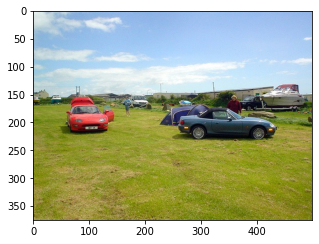

In [5]:
# change the idx to test different samples

idx = 0
imgstr='000240'
#raw_img = Image.open('./images/pascal/sample%d.jpg' % idx).convert('RGB')
raw_img = Image.open('../../VOC2007/JPEGImages/'+imgstr+'.jpg').convert('RGB')
#raw_img = Image.open('sdata/sample2.jpg').convert('RGB')
input_var = transformer(raw_img).unsqueeze(0).cuda().requires_grad_()
# plot raw image
plt.figure(figsize=(5,5))
plt.imshow(raw_img)

In [6]:
## predict count

model = model.eval()
confidence,density_map,_ = model(input_var,1)
count_den = F.adaptive_avg_pool2d(density_map, 1).squeeze(2).squeeze(2).detach().cpu().numpy()[0]
density_map=density_map.squeeze().detach().cpu().numpy()
confidence=confidence.cpu().detach().numpy()
confidence[confidence<0]=0
confidence=confidence[0]
confidence[confidence>0]=1
count=np.round(confidence*count_den)

print('***************************')
print('Object count in the image:')
for index in range(len(class_names)):
    if count[index]:
        print(colored('    [class_idx: %d] %s (%.2f)' % (index, class_names[index], count[index]),'blue'))
posi_cls=[i for i in range(len(class_names)) if count[i]] # index of positive classes in the image


***************************
Object count in the image:
    [class_idx: 6] car (7.00)


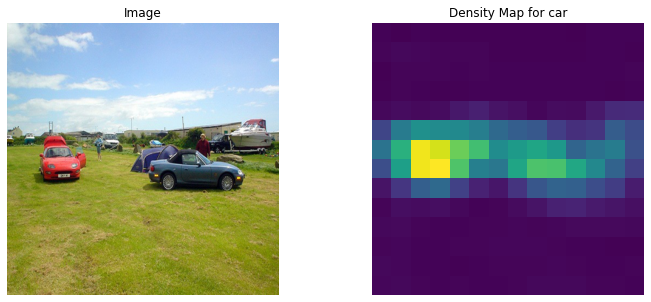

In [7]:
## predict instance segmentation

model = model.inference()
#with open('./images/pascal/sample%d.json' % idx, 'r') as f:
# with open('sdata/s2.json', 'r') as f:
#    proposals_cob = list(map(modules.rle_decode, json.load(f)))

from scipy.io import loadmat
def ismember(B, A):
    result = np.zeros(B.shape)
    result[np.where(B in A)] = 1
    return result
x = loadmat('../../COB/'+imgstr+'.mat')
proposals_cob = []
for i in range(200):
    proposals_cob.append(ismember(x['superpixels'], x['labels'][i]))



instance_list,_ = model(input_var,1,peak_threshold=20, 
                                  retrieval_cfg=dict(proposals=proposals_cob,
                                  proposal_count=100, 
                                  param=(0.95, 1e-5, 0.8,0.2)))
# visualization
if instance_list is None:
    print('No object detected')
else:
    # peak response maps are merged if they select similar proposals
    vis = modules.prm_visualize(instance_list, class_names=class_names)
    # f, axarr = plt.subplots(1, 2+len(posi_cls), figsize=(12, 5))
    f, axarr = plt.subplots(1, 1+len(posi_cls), figsize=(12, 5))
    axarr[0].imshow(imresize(raw_img, (image_size, image_size), interp='bicubic'))
    axarr[0].set_title('Image')
    axarr[0].axis('off')

    #axarr[1].imshow(vis[0])
    #axarr[1].set_title('Prediction')
    #axarr[1].axis('off')

    for i in range(len(posi_cls)):
        # axarr[2+i].imshow(density_map[posi_cls[i]])
        # axarr[2+i].set_title('Density Map for '+class_names[posi_cls[i]])
        # axarr[2+i].axis('off')

        axarr[1+i].imshow(density_map[posi_cls[i]])
        axarr[1+i].set_title('Density Map for '+class_names[posi_cls[i]])
        axarr[1+i].axis('off')
    plt.show()